In [11]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [12]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
from skimage.metrics import structural_similarity as ssim
import os
import copy
import cv2
from IPython.display import Image 
from google.colab.patches import cv2_imshow
from torch.optim import lr_scheduler
from torch.utils.data.dataset import Dataset
from skimage import io, transform
from PIL import Image, ImageOps
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.6.0+cu101
Torchvision Version:  0.7.0+cu101


In [13]:
# #this data loading code runs for samarth

# train_image_path = './drive/My Drive/AML_assignments/Train_images/Images/'
# train_mask_path = './drive/My Drive/AML_assignments/Train_masks/Contours_black/'
# validation_image_path = './drive/My Drive/AML_assignments/Test_images/set1/'
# validation_mask_path = './drive/My Drive/AML_assignments/Test_masks/Contours_black_test1set/'

#this data loading code runs for varsha 
train_image_path = './drive/My Drive/AML assignment/AML_assignments/Train_images/Images/'
train_mask_path = './drive/My Drive/AML assignment/AML_assignments/Train_masks/Contours_black/'
validation_image_path = './drive/My Drive/AML assignment/AML_assignments/Test_images/set1/'
validation_mask_path = './drive/My Drive/AML assignment/AML_assignments/Test_masks/Contours_black_test1set/'

batch_size = 16
num_epochs = 50
split_percentage = 0.7

In [14]:
# Model definition

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True))   

class UNet(nn.Module):
    def __init__(self):
        super().__init__()                
        self.dconv_down1 = double_conv(1, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)        
        self.conv_last = nn.Conv2d(64,1, 1)
        self.sig_act = nn.Sigmoid()
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)        
        x = self.dconv_down4(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)  
        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)         
        x = self.dconv_up1(x)
        out = self.conv_last(x)
        out = self.sig_act(out)
        return out

def unet(pretrained=False, progress=True, **kwargs):
    model = UNet(**kwargs)
    return model

In [15]:
# Initialize the model for this run
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = unet()

# send model to device-cuda
model_ft = model_ft.to(device)

# Print the model we just instantiated
# print(model_ft)

#Summary of the model
# from torchsummary import summary
# y = (1,216,216) #works for (216,256) too
# summary(model_ft, y)

In [16]:
class RV_Data_train(Dataset):
    def __init__(self, path, transforms=None):
        self.path = path
        self.list = os.listdir(self.path)   
        self.transforms = transforms
        
    def __getitem__(self, index):
        # stuff
        image_path = train_image_path
        mask_path = train_mask_path
        image = Image.open(image_path+self.list[index])
        mask = Image.open(mask_path+self.list[index])
        if self.transforms is not None:
            image = self.transforms(image)
            mask = self.transforms(mask)
            return (image, mask)

    def __len__(self):
        return len(self.list)

class RV_Data_valid(Dataset):
    def __init__(self, path, transforms=None):
        self.path = path
        self.list = os.listdir(self.path)   
        self.transforms = transforms
        
    def __getitem__(self, index):
        # stuff
        image_path = validation_image_path
        mask_path = validation_mask_path
        image = Image.open(image_path+self.list[index])
        mask = Image.open(mask_path+self.list[index])
        if self.transforms is not None:
            image = self.transforms(image)
            mask = self.transforms(mask)
            return (image, mask)

    def __len__(self):
        return len(self.list)

In [17]:
# train data generator
params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 0}
transform = transforms.Compose([transforms.Resize((216,216)), transforms.Grayscale(), transforms.ToTensor()
                                   ]) 
training_set1 = RV_Data_train(train_image_path,transform)

train_size = int(split_percentage * len(training_set1))
remaining = len(training_set1) - train_size
training_set, _ = torch.utils.data.random_split(training_set1,
                                        [train_size, remaining])

training_generator = torch.utils.data.DataLoader(training_set, **params)

#validation data generator

validation_set = RV_Data_valid(validation_image_path,transform)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

In [18]:
print('Split percentage is ',split_percentage*100)
print('Length of train dataset is:', len(training_set))
print('Length of train dataloader is:', len(training_generator))

print('Length of validation dataset is:', len(validation_set))
print('Length of validation dataloader is:', len(validation_generator))

Split percentage is  70.0
Length of train dataset is: 170
Length of train dataloader is: 11
Length of validation dataset is: 262
Length of validation dataloader is: 17


In [19]:
#PyTorch
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()
 
    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)     
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
 
        return (1 - dice_loss)

Learning rate 0.01
Epoch 0/49
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train Loss: 0.8941 
Validation Loss: 0.9039 
Time taken for one epoch 0m 51s
Epoch 1/49
----------
Train Loss: 0.8952 
Validation Loss: 0.9041 
Time taken for one epoch 1m 6s
Epoch 2/49
----------
Train Loss: 0.8948 
Validation Loss: 0.9044 
Time taken for one epoch 1m 21s
Epoch 3/49
----------
Train Loss: 0.8944 
Validation Loss: 0.9047 
Time taken for one epoch 1m 36s
Epoch 4/49
----------
Train Loss: 0.8954 
Validation Loss: 0.9027 
Time taken for one epoch 1m 51s
Epoch 5/49
----------
Train Loss: 0.8936 
Validation Loss: 0.9048 
Time taken for one epoch 2m 6s
Epoch 6/49
----------
Train Loss: 0.8937 
Validation Loss: 0.9033 
Time taken for one epoch 2m 21s
Epoch 7/49
----------
Train Loss: 0.8954 
Validation Loss: 0.9031 
Time taken for one epoch 2m 36s
Epoch 8/49
----------
Train Loss: 0.8935 
Validation Loss: 0.9040 
Time taken for one epoch 2m 51s
Epoch 9/49
----------
Train Loss: 0.8951 
Validation Loss: 0.9035 
Time taken for one epoch 3m 6s
Epoch 10/49
----------
Train Loss: 

<Figure size 432x288 with 0 Axes>

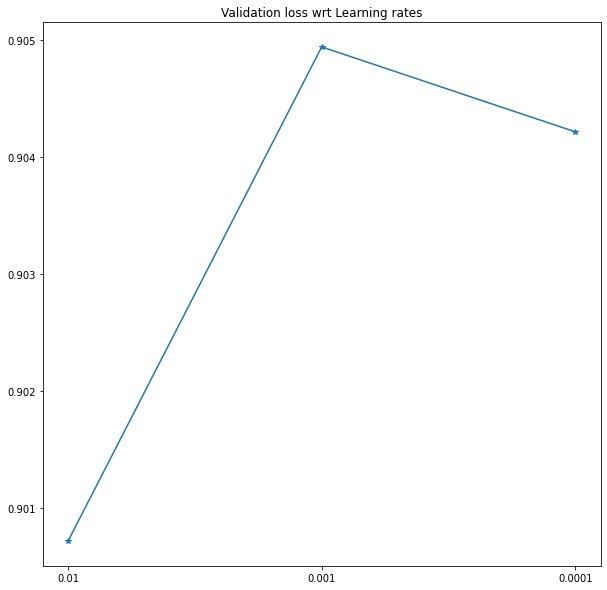

<Figure size 432x288 with 0 Axes>

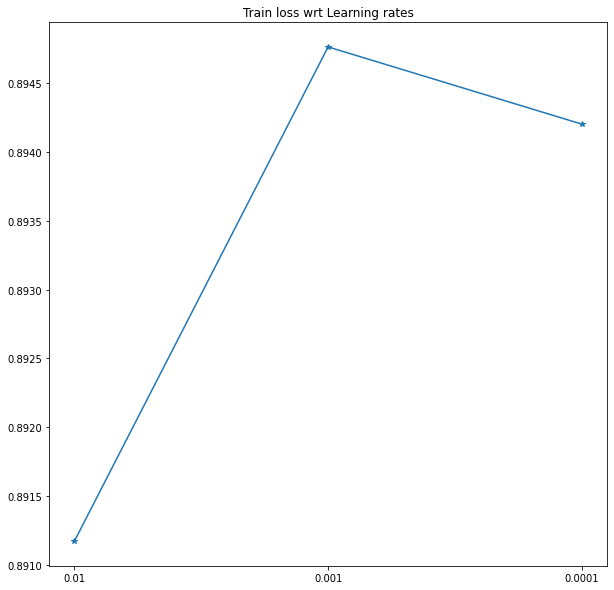

<Figure size 432x288 with 0 Axes>

In [20]:
avg_train_loss = []
avg_val_loss = []
since = time.time()
lr_list = [0.01,0.001,.0001]

criterion = DiceLoss()
for lr in lr_list:
    model_ft = unet()
    model_ft = model_ft.to(device)
    # optimizer = torch.optim.Adam(model_ft.parameters(), lr = lr)
    optimizer = torch.optim.SGD(model_ft.parameters(), lr=lr, momentum=0.9)
    # optimizer = torch.optim.Adagrad(model_ft.parameters(), lr=lr, initial_accumulator_value=0, eps=1e-10)
    from torch.optim.lr_scheduler import StepLR
    steps = 10
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, steps)
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=steps, gamma=0.1)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1, last_epoch=-1)
    print('Learning rate {}'.format(lr))
    
    loss_train = []
    loss_valid = []
    running_loss = 0.0
    running_loss1 = 0.0

    for epoch in range(num_epochs):
        scheduler.step()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Training
        for imgs, masks in training_generator:
            
            # Transfer to GPU
            imgs, masks = imgs.to(device), masks.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model_ft(imgs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
      
        # print statistics
        epoch_loss = running_loss/len(training_generator)
        print('{} Loss: {:.4f} ' .format('Train', epoch_loss))
        loss_train.append(epoch_loss)
        running_loss = 0.0

        for imgs, masks in validation_generator:

            # Transfer to GPU
            imgs, masks = imgs.to(device), masks.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward  # backward and optimisation happen only in train phase!
            outputs = model_ft(imgs)
            loss = criterion(outputs, masks)
            loss.backward()
            running_loss1 += loss.item()
        
        # print statistics
        epoch_loss = running_loss1/ len(validation_generator)
        print('{} Loss: {:.4f} ' .format('Validation', epoch_loss))
        loss_valid.append(epoch_loss)
        running_loss1 = 0.0
            
        time_elapsed1 = time.time() - since
        print('Time taken for one epoch {:.0f}m {:.0f}s'.format(time_elapsed1 // 60, time_elapsed1 % 60))
        torch.save(model_ft.state_dict(), '/content/drive/My Drive/AML assignment/AML_assignments/Saved Model (Sachin)/model_SGD_Cosine_lr' +str(lr)+'_percentage' + str(split_percentage) +'.pt')

    print('Time taken for one loop is {:.0f}m {:.0f}s'.format(time_elapsed1 // 60, time_elapsed1 % 60))
    avg_train_loss.append(sum(loss_train)/len(loss_train))
    avg_val_loss.append(sum(loss_valid)/len(loss_valid))
        
print('Finished Training')
plt.figure(figsize=(10,10))
plt.title("Validation loss wrt Learning rates") 
plt.plot(avg_val_loss, "*-")
plt.xticks(np.arange(3), ('0.01', '0.001', '0.0001'))
plt.figure()

plt.figure(figsize=(10,10))
plt.title("Train loss wrt Learning rates") 
plt.plot(avg_train_loss, "*-")
plt.xticks(np.arange(3), ('0.01', '0.001', '0.0001'))
plt.figure()